In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
class MACDRSIStrategy(CtaTemplate):
    className = 'MACDRSIStrategy'
    author = 'Carey'
    # 策略参数
    MA_jPeriod = 20; MD_jPeriod = 20  #经参数优化，非核心参数
    obvlonglimit = 2; obvshortlimit = -2 #经参数优化，核心参数
    stopRatio = 0.04
    lot = 1
    # 策略变量
    transactionPrice = {} # 记录成交价格
    volat = {}
    trend = {}
    # 参数列表，保存了参数的名称
    paramList = [
                 "MA_jPeriod", "MD_jPeriod",
                 "obvlonglimit" , "obvshortlimit",
                 'stopRatio']                        ##参数列表不用写手数
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
                  "volat"
                  "trend"]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把本策略对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.volat = {s:0 for s in self.symbolList}
        self.trend = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    ####################################布林带做反转，能量潮做过滤################################# 
    ####################################经测试，不适用于小周期，即30min以下#########################
    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "60m")
        if not am30.inited:
            return            
        #定义布林带
        MA_j = ta.MA(am30.close,self.MA_jPeriod)
        MD_j = ta.STDDEV(am30.close,self.MD_jPeriod)
        Bolldown_j = MA_j - 2*MD_j
        Bollup_j = MA_j + 2*MD_j

        #布林带进出场信号
        Boll_long = (am30.close[-1] > Bolldown_j[-1]) and (am30.low[-3] <= Bolldown_j[-3])   #最低价小于布林带支撑线，取提前几天的值。值得商榷
        Boll_short = (am30.close[-1] < Bollup_j[-1]) and (am30.high[-3] >= Bollup_j[-3])        #核心参数。60min取前三天，30min取前一天效果好。
        
        #成交量做过滤
        obv = ta.OBV(am30.close,ta.LOG10(am30.volume))  #成交量太大，对其取对数，降低成交量变动数值大小
        obv_long = obv[-1]>2 #买入     核心参数，需要优化确定不同周期的最佳范围   30min小周期 obv[-1]>0 60min大周期obv[-1]>2
        obv_short = obv[-1]<2  #卖出       60min大周期obv[-1]<2 效果较好。 30min小周期obv[-1]<-2
        
        # 趋势为多头
        if (obv_long and Boll_long) and (self.posDict[symbol+'_LONG']==0):  
            if  (self.posDict[symbol+'_SHORT']==0):  #没有持仓
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 趋势为空头
        if (obv_short and Boll_short) and (self.posDict[symbol+'_SHORT']==0): 
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)               
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期
# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [4]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDRSIStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDRSIStrategy.on60MinBar at 0x1a19e227b8>, <__main__.MACDRSIStrategy object at 0x1042d1f60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MACDRSIStrategy.onBar at 0x1a19e22730>, <__main__.MACDRSIStrategy object at 0x1042d1f60>)
2018-12-16 23:32:19.942075	开始回测
2018-12-16 23:32:19.942112	策略初始化
2018-12-16 23:32:19.943041	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-16 23:32:20.962654	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 23:32:20.965138	载入完成，数据量：12000
2018-12-16 23:32:20.965449	策略初始化完成
2018-12-16 23:32:20.965487	策略启动完成
2018-12-16 23:32:20.965535	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-16 23:32:20.981223	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-16 23:32:31.763473	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 23:32:31.822641	载入完成，数据量：261728
2018-12-16 23:32:31.822937	当前回放数据:[20180601 

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 4376, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
LONG stopLoss:32:36.975491	Progress: 5%    
LONG stopLoss:32:37.081275	Progress: 6%    
LONG stopLoss
LONG stopLoss:32:37.546608	Progress: 11%    
LONG stopLoss:32:37.943409	Progress: 15%    
SHORT stopLoss32:38.942885	Progress: 25%    
LONG takeProfit2:39.217037	Progress: 28%    
LONG stopLoss:32:39.409911	Progress: 30%    
SHORT takePro

In [5]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-27 21:00:00,多,,,0.0,,开仓,89,,3788.52,0.0,None,,,89,2018-11-27 21:00:00,1,89,BTCUSDT:binance,89
2018-11-28 22:25:00,空,,,0.0,,平仓,90,,4252.29,0.0,None,,,90,2018-11-28 22:25:00,1,90,BTCUSDT:binance,90
2018-11-30 18:00:00,多,,,0.0,,开仓,91,,4225.14,0.0,None,,,91,2018-11-30 18:00:00,1,91,BTCUSDT:binance,91
2018-11-30 19:05:00,空,,,0.0,,平仓,92,,4045.10,0.0,None,,,92,2018-11-30 19:05:00,1,92,BTCUSDT:binance,92
2018-11-30 22:00:00,多,,,0.0,,开仓,93,,4040.00,0.0,None,,,93,2018-11-30 22:00:00,1,93,BTCUSDT:binance,93


2018-12-16 23:32:45.802807	计算按日统计结果
2018-12-16 23:32:45.841643	------------------------------
2018-12-16 23:32:45.841744	首个交易日：	2018-06-01 00:00:00
2018-12-16 23:32:45.841776	最后交易日：	2018-12-01 00:00:00
2018-12-16 23:32:45.841801	总交易日：	184
2018-12-16 23:32:45.841826	盈利交易日	103
2018-12-16 23:32:45.841996	亏损交易日：	73
2018-12-16 23:32:45.842025	起始资金：	100000
2018-12-16 23:32:45.842085	结束资金：	106,542.6
2018-12-16 23:32:45.842120	总收益率：	6.54%
2018-12-16 23:32:45.842152	年化收益：	8.53%
2018-12-16 23:32:45.842184	总盈亏：	6,542.6
2018-12-16 23:32:45.842215	最大回撤: 	-1,046.78
2018-12-16 23:32:45.842246	百分比最大回撤: -1.04%
2018-12-16 23:32:45.842277	总手续费：	298.9
2018-12-16 23:32:45.842308	总滑点：	0.19
2018-12-16 23:32:45.842339	总成交金额：	597,794.22
2018-12-16 23:32:45.842365	总成交笔数：	93
2018-12-16 23:32:45.842394	日均盈亏：	35.56
2018-12-16 23:32:45.842424	日均手续费：	1.62
2018-12-16 23:32:45.842454	日均滑点：	0.0
2018-12-16 23:32:45.842485	日均成交金额：	3,248.88
2018-12-16 23:32:45.842515	日均成交笔数：	0.51
2018-12-16 23:32:45.842540	日均收益率：	0.03%
20

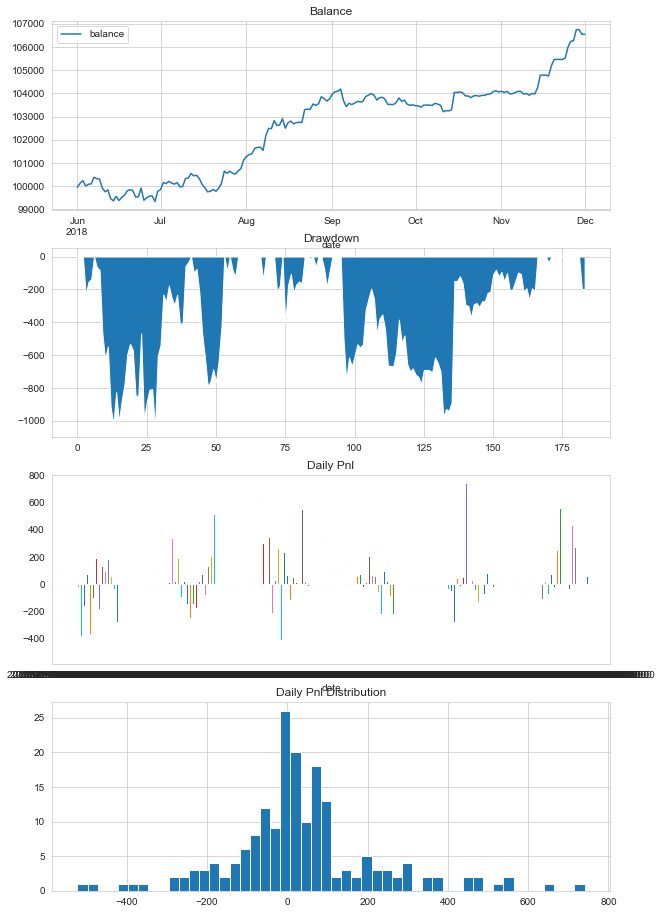

In [6]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 23:32:47.978927	计算回测结果
2018-12-16 23:32:47.983599	------------------------------
2018-12-16 23:32:47.983731	第一笔交易：	2018-06-06 23:00:00
2018-12-16 23:32:47.983762	最后一笔交易：	2018-12-01 11:58:00
2018-12-16 23:32:47.983794	总交易次数：	47
2018-12-16 23:32:47.983929	总盈亏：	6,540.58
2018-12-16 23:32:47.983996	最大回撤: 	-903.71
2018-12-16 23:32:47.984032	平均每笔盈利：	139.16
2018-12-16 23:32:47.984064	平均每笔滑点：	0.0
2018-12-16 23:32:47.984097	平均每笔佣金：	6.4
2018-12-16 23:32:47.984139	胜率		61.7%
2018-12-16 23:32:47.984175	盈利交易平均值	357.51
2018-12-16 23:32:47.984209	亏损交易平均值	-212.63
2018-12-16 23:32:47.984242	盈亏比：	1.68


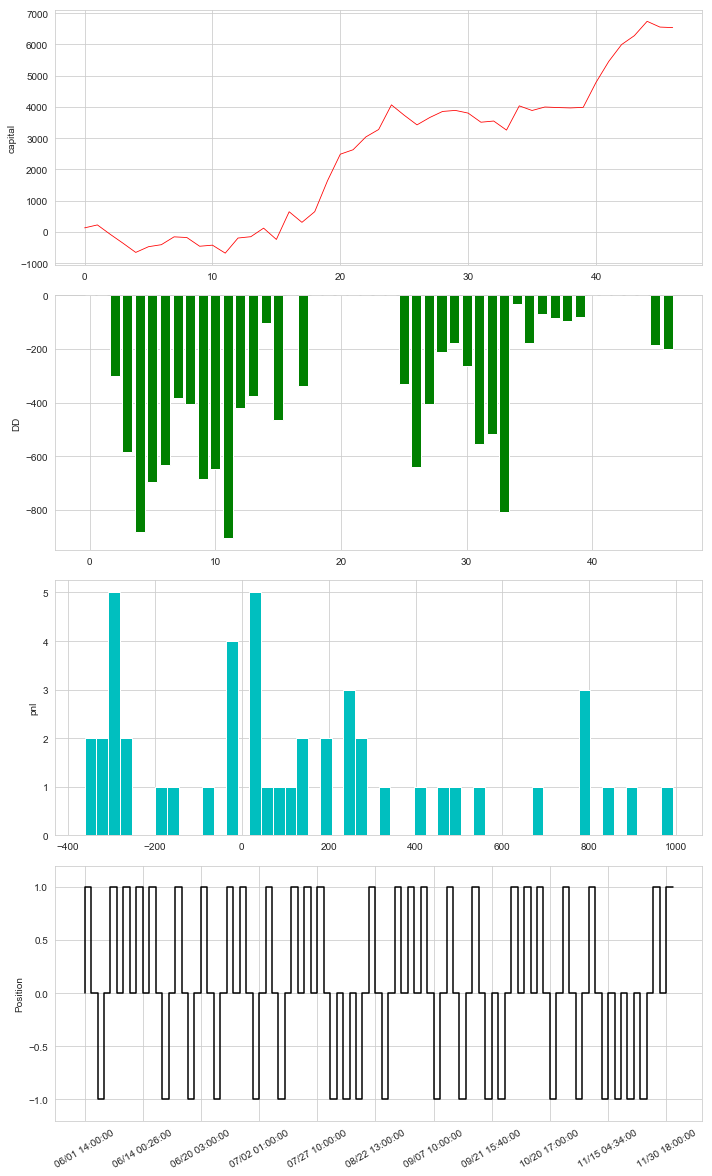

In [7]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [9]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-16 23:39:00.982139	计算按日统计结果


In [10]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-12-01 00:00:00
totalDays                           184
profitDays                          103
lossDays                             73
endBalance                       106543
maxDrawdown                    -1046.78
maxDdPercent                   -1.04275
totalNetPnl                      6542.6
dailyNetPnl                     35.5576
totalCommission                 298.897
dailyCommission                 1.62444
totalSlippage                     0.186
dailySlippage                0.00101087
totalTurnover                    597794
dailyTurnover                   3248.88
totalTradeCount                      93
dailyTradeCount                0.505435
totalReturn                      6.5426
annualizedReturn                8.53382
dailyReturn                   0.0346953
returnStd                      0.182295
sharpeRatio                      2.9485
dtype: object
